# Libraries and Settings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

# Import Data

In [14]:
raw = pd.read_csv('../data/Zip_Zri_MultiFamilyResidenceRental.csv')
raw.columns = raw.columns.str.replace('RegionName', 'zip')
raw = raw[raw['City'] == 'New York']

In [15]:
region = raw.iloc[:,:7].set_index('zip')
data = pd.concat([raw['zip'],raw.iloc[:,11:-1]],axis=1).set_index('zip')

In [16]:
region.shape

(150, 6)

# Data Cleaning

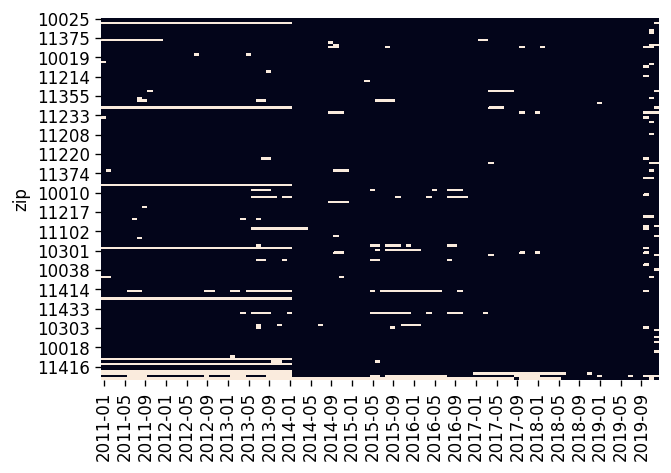

In [17]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
sns.heatmap(data.isnull(), cbar=False)

In [18]:
good = data.isna().mean(axis=1) <= 0.2
region = region[good]
data = data[good]

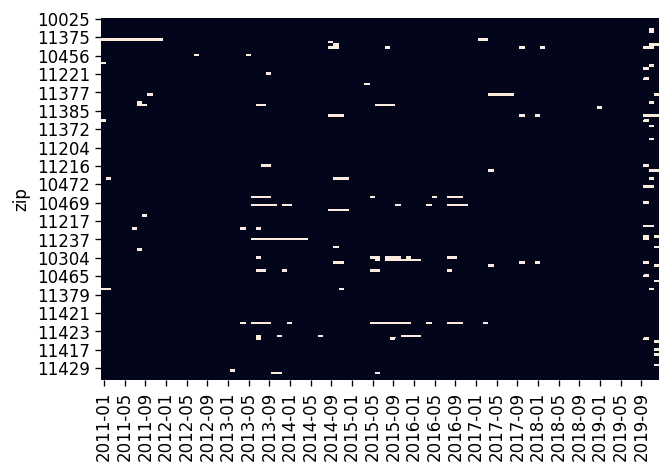

In [19]:
sns.heatmap(data.isnull(), cbar=False)

In [20]:
ny = data.interpolate(method='linear',limit_direction='both', axis=1)

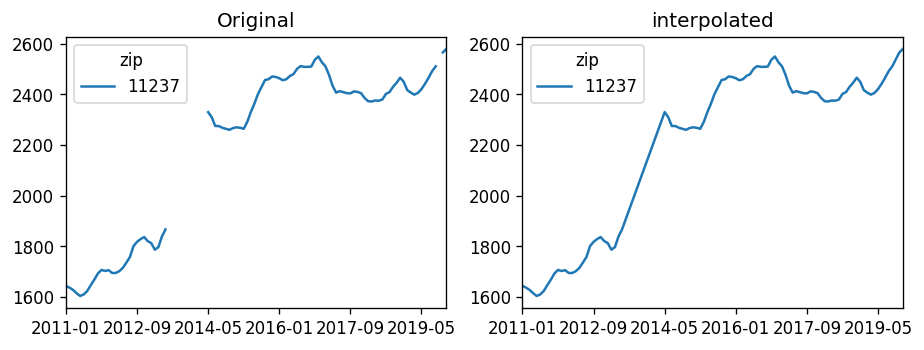

In [30]:
def plot_interpolate(zipcode):
    plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
    fig, axes = plt.subplots(1, 2)
    data[data.index==zipcode].T.plot(ax=axes[0])
    axes[0].set_title('Original')
    ny[ny.index==zipcode].T.plot(ax=axes[1])
    axes[1].set_title('interpolated')
    
plot_interpolate(11237)

# EDA

In [49]:
def get_change(ts_data):
    ts = ts_data.T
    ts_pre = ts.shift()
    return(((ts-ts_pre)/ts_pre).iloc[1:,:].T)

change = get_change(ny)

## Cluster Analysis

In [50]:
from sklearn.cluster import KMeans
from collections import defaultdict

In [51]:
kmeans = KMeans(n_init=40)

In [52]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

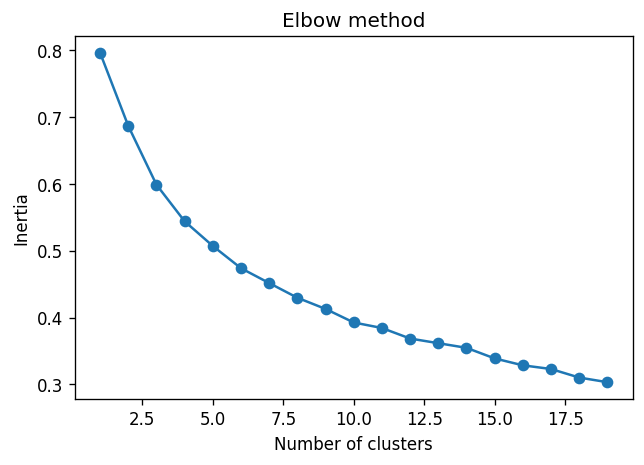

In [53]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
plot_inertia(kmeans, change, range(1, 20))

In [92]:
ngroup = 8

def fit_kmeans(ngroup,ts_data):
    kmeans = KMeans(ngroup, n_init=40)
    kmeans.fit(ts_data)

    cluster_groups = kmeans.predict(ts_data)

    similar_by_cluster = defaultdict(list)
    for a, b in zip(cluster_groups, ny.index):
           similar_by_cluster[a].append(b)

    for key,value in similar_by_cluster.items():
        print(f'Group {key}: {len(value)}')
        
    return(cluster_groups, similar_by_cluster)

cluster_groups, similar_by_cluster = fit_kmeans(ngroup, change)

Group 4: 23
Group 3: 26
Group 6: 15
Group 5: 11
Group 2: 28
Group 7: 4
Group 0: 10
Group 1: 21


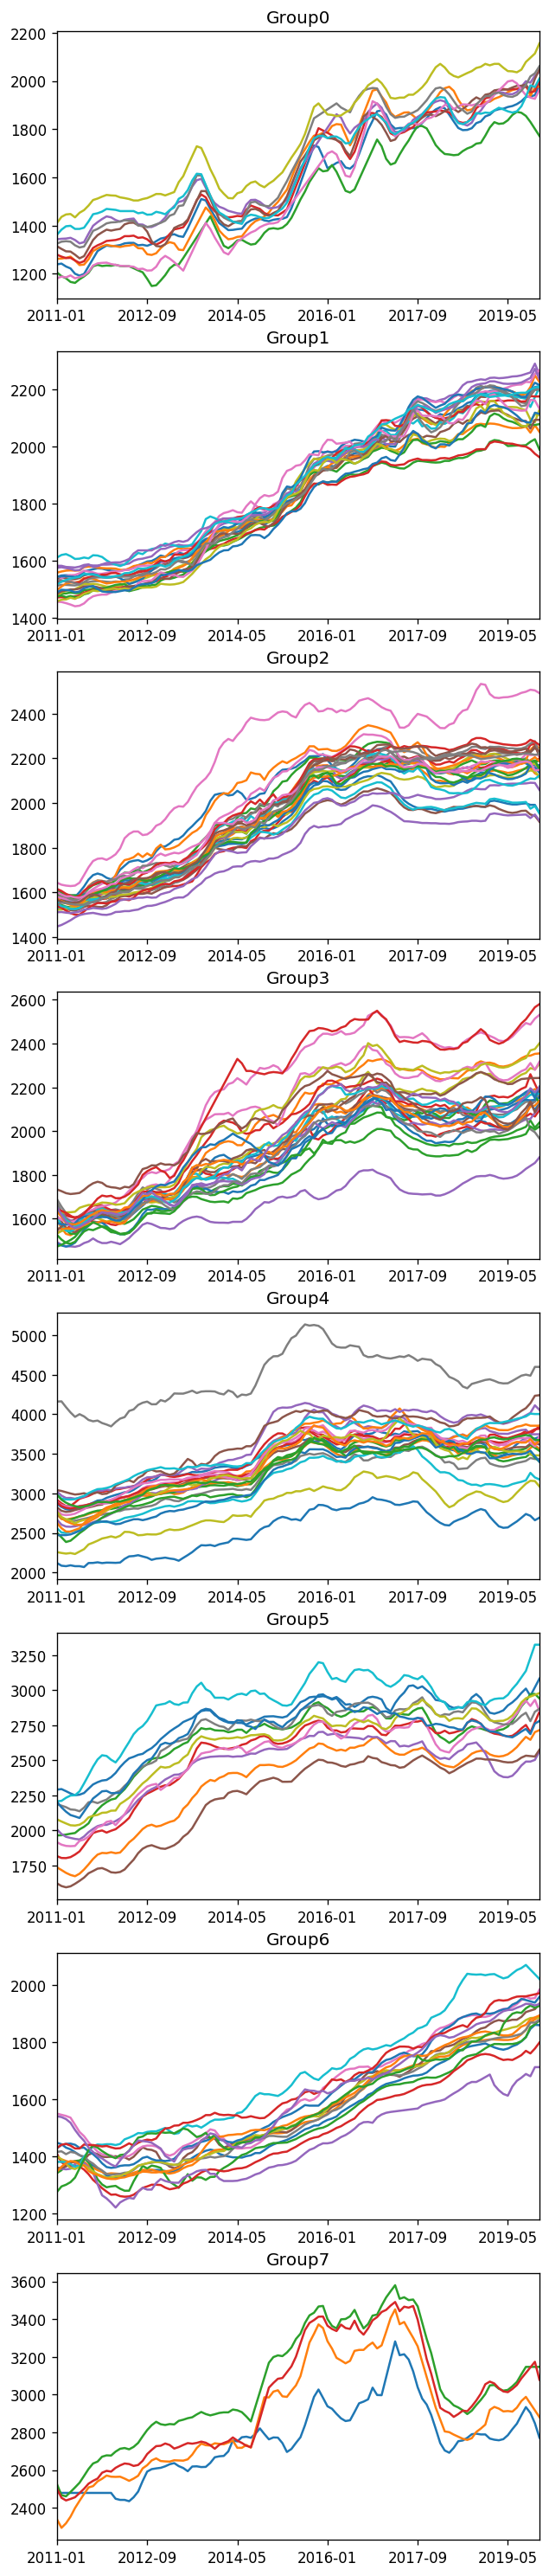

In [93]:
plt.rcParams.update({'figure.figsize':(6,4*ngroup), 'figure.dpi':120})
fig, axes = plt.subplots(ngroup, 1)
for g in range(ngroup):
    for zipcode in similar_by_cluster[g]:
        ny[ny.index==zipcode].T.plot(ax=axes[g])
        axes[g].set_title('Group'+str(g))
        axes[g].legend().set_visible(False)

In [94]:
kmeans_group = pd.DataFrame({'ZipCode':ny.index.map(str),'Group':cluster_groups})
# kmeans_group.to_csv('../data/kmeans_group.csv')

## Visualization

Reference:
- https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db20
- https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps

In [95]:
import folium

In [96]:
ny_geo_all = f'nyu-2451-34509-geojson.json'

m_kmeans = folium.Map(location=[40.730610, -73.935242],zoom_start=11)

folium.Choropleth(
    geo_data=ny_geo_all,
    name='choropleth',
    data=kmeans_group,
    columns=['ZipCode', 'Group'],
    key_on='feature.properties.zcta', # Use 'feature', not 'features'. this seems to be a bug
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = np.arange(ngroup+1),
    legend_name='K-Means Group'
).add_to(m_kmeans)

folium.LayerControl().add_to(m_kmeans)

m_kmeans

In [97]:
m_kmeans.save('nyc_kmeans.html')

In [105]:
rent_zip = pd.DataFrame({'zip':ny.index.map(str),'2019':ny.iloc[:,-12:].mean(axis=1)})

In [110]:
ny_geo_all = f'nyu-2451-34509-geojson.json'

m_rent = folium.Map(location=[40.730610, -73.935242],zoom_start=11)

folium.Choropleth(
    geo_data=ny_geo_all,
    name='choropleth',
    data=rent_zip,
    columns=['zip', '2019'],
    key_on='feature.properties.zcta', # Use 'feature', not 'features'. this seems to be a bug
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = 10,
    legend_name='Zillow Rent Index in 2019-12'
).add_to(m_rent)

folium.LayerControl().add_to(m_rent)

m_rent

In [111]:
m_rent.save('nyc_2019.html')